# Question 2

## Imports

In [43]:
import pandas as pd
from smartodds.data_fetching.fetch_data import \
    get_fixture_conference_summary_date
from tabulate import tabulate
from smartodds.data_fetching.fetch_data import \
    get_conference_home_advantage_info
from smartodds.data_fetching.fetch_data import filter_for_same_conference
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from smartodds.data_fetching.fetch_data import \
    get_conference_home_advantage_info_with_confidence_intervals, \
    compare_conference_home_advantage

## Load Data

In [44]:
df = pd.read_csv('merged_data.csv')

## 2.1

What is the percentage of matches in the fitset where the teams belong to different conferences?

In [3]:
fixture_conference_summary = get_fixture_conference_summary_date(df)

Approximately 27 % of matches in fitset contain teams from different conferences.

In [4]:
print(tabulate(fixture_conference_summary, headers='keys', tablefmt='pretty'))

+---+----------------+-----------------------+----------------------------+-------------------+--------------------+
|   |    Dataset     | same_conference_count | different_conference_count |  true_percentage  |  false_percentage  |
+---+----------------+-----------------------+----------------------------+-------------------+--------------------+
| 0 |     fitset     |          997          |            373             | 72.77372262773723 | 27.226277372262775 |
| 1 | simulation_set |          240          |            101             | 70.38123167155426 | 29.61876832844575  |
+---+----------------+-----------------------+----------------------------+-------------------+--------------------+


## 2.2

Looking only at matches between teams in the same conference, does the value of home advantage
differ between the Eastern Conference and the Western Conference? Is the difference statistically
significant?

Basic summary stats for home advantage.

There is roughly a 0.5 goal difference in home advantage between the Eastern and Western Conference. We will inspect this in further detail.

In [5]:
conference_home_advantage = get_conference_home_advantage_info(df)
print(tabulate(conference_home_advantage, headers='keys', tablefmt='pretty'))

+---+------------+--------------------+--------------------+----------------+---------------------+
|   | Conference |  mean_home_goals   |  mean_away_goals   | total_fixtures | mean_home_advantage |
+---+------------+--------------------+--------------------+----------------+---------------------+
| 0 |  Eastern   | 1.6590779738190096 | 1.1673306772908367 |      1757      | 0.49174729652817284 |
| 1 |  Western   | 1.7069616837560713 | 1.1656772800863464 |      1853      | 0.5412844036697249  |
+---+------------+--------------------+--------------------+----------------+---------------------+


### Independent 2 Sample T Test

**Assumptions:** <br>
    - Independence (Possibly safe to assume since separate conferences and tables) <br>
    - Normality (CHECK) <br>
    - Equal Variance (If not can use Welch's T Test) <br>

**Independence**

We can assume independence since we are comparing two separate conferences, with distinct teams.

**Normality**

We first plot the distribution of goal differences for each conference, to the eye it appears to be normally distributed.

In [11]:
same_conference_df = filter_for_same_conference(df)

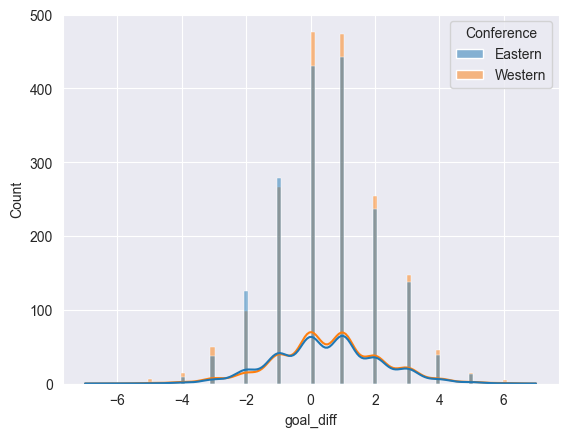

In [12]:
sns.histplot(same_conference_df, x='goal_diff', hue='Conference', kde=True)
plt.show()

We can also perform a Shapiro-Wilk test to confirm normality.  We test the null hypothesis that the data is normally distributed.
We use a significance level of 0.05.

In [19]:
stat, p = shapiro(df['goal_diff'])

In [18]:
print(f'Statistics={stat}, p={p}')
print(f"{'Normally distributed' if p > 0.05 else 'Not normally distributed'}")

Statistics=0.9652935245095273, p=1.2109139603618752e-28
Not normally distributed


### Boostrap Approach

Since the data is not normally distributed, we will use a boostrap approach to test for significance.
We create a 95% confidence interval for both conferences for the goal difference.
We use 10000 samples (with replacement) to create the confidence intervals.

If the confidence intervals do not overlap, we can conclude that the difference in home advantage is statistically significant.

In [20]:
conference_home_advantage_info = get_conference_home_advantage_info_with_confidence_intervals(same_conference_df)
compare_conference_home_advantage(conference_home_advantage_info)

'The home advantage is not statistically different between the Eastern and Western Conferences.'

In [23]:
print(tabulate(conference_home_advantage_info, headers='keys', tablefmt='pretty'))

+---+------------+--------------------+--------------------+--------------------+--------------------+----------------+---------------------+--------------------+--------------------+
|   | Conference |  mean_home_goals   |   sd_home_goals    |  mean_away_goals   |   sd_away_goals    | total_fixtures |   home_advantage    |      ci_lower      |      ci_upper      |
+---+------------+--------------------+--------------------+--------------------+--------------------+----------------+---------------------+--------------------+--------------------+
| 0 |  Eastern   | 1.6590779738190096 | 1.2401749881850592 | 1.1673306772908367 | 1.098457393414086  |      1757      | 0.49174729652817284 | 0.4154809334092202 | 0.5674445076835515 |
| 1 |  Western   | 1.7069616837560713 | 1.2650562341370102 | 1.1656772800863464 | 1.1149235741256849 |      1853      | 0.5412844036697249  | 0.4651915812196439 | 0.6168375607123584 |
+---+------------+--------------------+--------------------+--------------------

## 2.3

Can you spot any seasonality in the data (for example, higher-scoring matches during a certain
period of the year)? What could cause the pattern you observe?

We will plot the total goals scored for each month to see if there is any seasonality in the data.  Ideally we could reorder the months to be in order (of MLS season) but for now we will leave them as is.

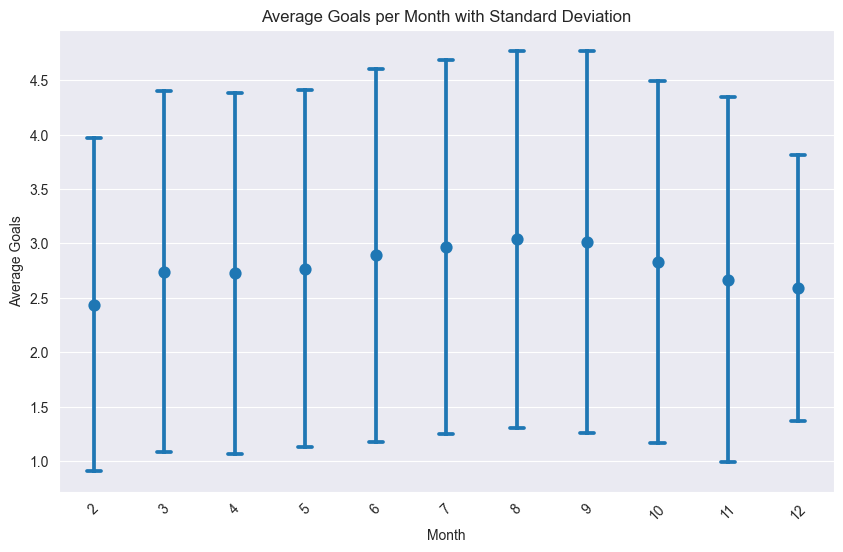

In [73]:
plt.figure(figsize=(10, 6))
sns.pointplot(x='month', y='total_goals', data=df, errorbar='sd', capsize=0.2, linestyles='')
plt.title('Average Goals per Month with Standard Deviation')
plt.ylabel('Average Goals')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.show()

There does seem to be apparent differences in the total goals scored for each month.  We will explore this further.

In [40]:
season_start_end = df.groupby('Season')['Date'].agg(['min', 'max'])
month_counts = df['month'].value_counts().sort_index().reset_index()

In [38]:
print(tabulate(season_start_end, headers='keys', tablefmt='pretty'))

+--------+------------+------------+
| Season |    min     |    max     |
+--------+------------+------------+
|  2012  | 2012-03-10 | 2012-12-01 |
|  2013  | 2013-03-02 | 2013-12-07 |
|  2014  | 2014-03-08 | 2014-12-07 |
|  2015  | 2015-03-07 | 2015-12-06 |
|  2016  | 2016-03-06 | 2016-12-11 |
|  2017  | 2017-03-04 | 2017-12-09 |
|  2018  | 2018-03-03 | 2018-12-09 |
|  2019  | 2019-03-02 | 2019-11-10 |
|  2020  | 2020-02-29 | 2020-12-13 |
|  2021  | 2021-04-17 | 2021-12-11 |
|  2022  | 2022-02-26 | 2022-11-05 |
|  2023  | 2023-02-25 | 2023-12-09 |
|  2024  | 2024-02-22 | 2024-06-23 |
+--------+------------+------------+


We see there is no fixtures in January, extremely low fixture counts for the February and December months, low counts for November, and higher counts for all other months.  This is likely due to the playoff structure of the MLS season, happening towards the end of the year.

In [39]:
print(tabulate(month_counts, headers='keys', tablefmt='pretty'))

+----+-------+-------+
|    | month | count |
+----+-------+-------+
| 0  |   5   |  707  |
| 1  |   9   |  671  |
| 2  |   7   |  662  |
| 3  |   8   |  620  |
| 4  |  10   |  572  |
| 5  |   4   |  569  |
| 6  |   6   |  506  |
| 7  |   3   |  489  |
| 8  |  11   |  167  |
| 9  |   2   |  48   |
| 10 |  12   |  22   |
+----+-------+-------+


We add a game number column to the dataframe to see if there is any seasonality in the total goals scored by game number.  This is to deal with the issue of varying fixture counts per month, and varying schedule lengths per season.

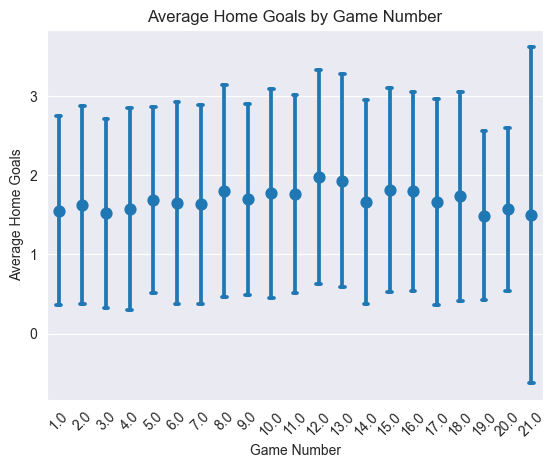

In [74]:
sns.pointplot(x='home_game_number', y='HG', data=df, errorbar='sd', capsize=0.2, linestyles='')
plt.title('Average Home Goals by Game Number')
plt.ylabel('Average Home Goals')
plt.xlabel('Game Number')
plt.xticks(rotation=45)
plt.show()

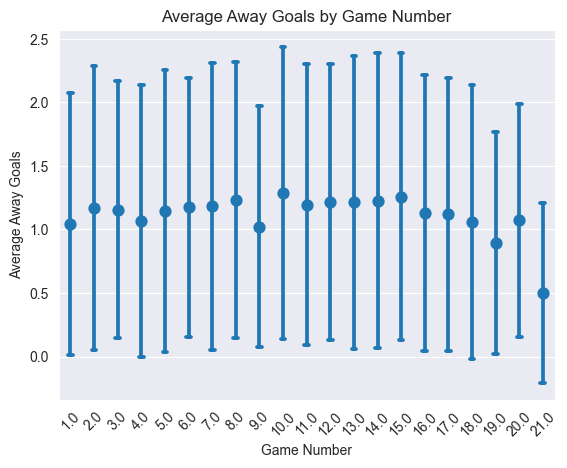

In [75]:
sns.pointplot(x='away_game_number', y='AG', data=df, errorbar='sd', capsize=0.2, linestyles='')
plt.title('Average Away Goals by Game Number')
plt.ylabel('Average Away Goals')
plt.xlabel('Game Number')
plt.xticks(rotation=45)
plt.show()

### Conclusion

There appears to be a trend of increasing goals as the season progresses, which then decreases again towards the end of the season.  This is likely due to the playoff structure of the MLS season, with teams playing more defensively towards the end of the season, (especially in knockout games).
The increase may be due to fatigue, i.e. teams tired in the middle of the season, leading to more goals. Or it may be a result of rotation, injuries, suspensions etc, at the start of the season there is likely to be near full strength teams, possibly leading to less goals.